In [23]:
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.cmap'] = 'gray'

In [33]:
def plot_two_imgs(img1, img2):
    # plot images
    plt.figure(figsize=(12,8))
    plt.subplot(1, 2, 1)
    plt.imshow(img1)

    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    

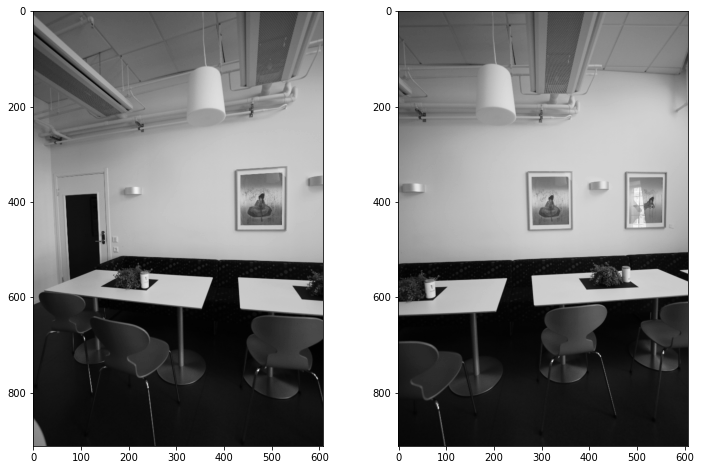

In [34]:
# Load our images
img1 = cv2.imread("/Users/ann/Documents/GitHub/Computer-Vision-1/Homework 1/SourceImages/stitch_l.png")
img2 = cv2.imread("/Users/ann/Documents/GitHub/Computer-Vision-1/Homework 1/SourceImages/stitch_m.png")

img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

plot_two_imgs(img1_gray, img2_gray)

In [35]:
def drawMatches(img1, keypoints1, img2, keypoints2, matches):
    r, c = img1.shape[:2]
    r1, c1 = img2.shape[:2]

    # Create a blank image with the size of the first image + second image
    output_img = np.zeros((max([r, r1]), c+c1, 3), dtype='uint8')
    output_img[:r, :c, :] = np.dstack([img1, img1, img1])
    output_img[:r1, c:c+c1, :] = np.dstack([img2, img2, img2])

    # Go over all of the matching points and extract them
    for match in matches:
        img1_idx = match.queryIdx
        img2_idx = match.trainIdx
        (x1, y1) = keypoints1[img1_idx].pt
        (x2, y2) = keypoints2[img2_idx].pt

        # Draw circles on the keypoints
        cv2.circle(output_img, (int(x1),int(y1)), 4, (0, 255, 255), 1)
        cv2.circle(output_img, (int(x2)+c,int(y2)), 4, (0, 255, 255), 1)

        # Connect the same keypoints
        cv2.line(output_img, (int(x1),int(y1)), (int(x2)+c,int(y2)), (0, 255, 255), 1)

    return output_img

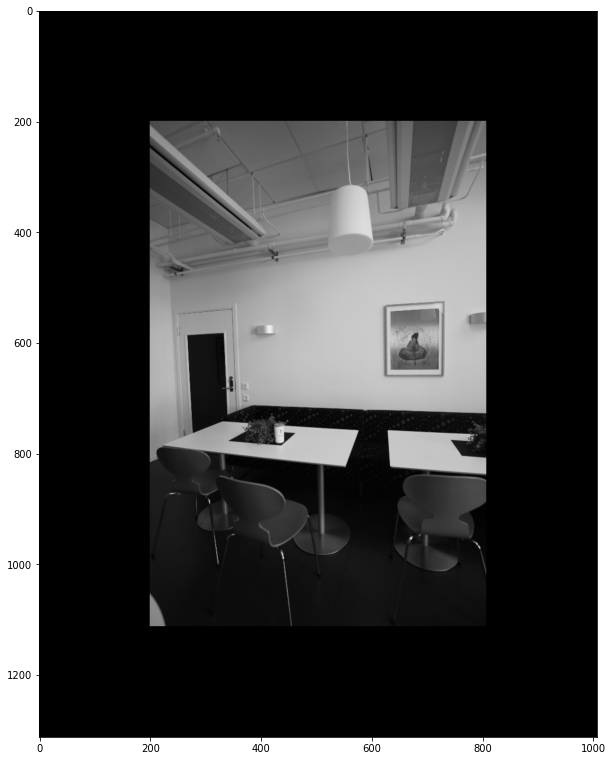

In [36]:
border = 200
img1 = cv2.copyMakeBorder(img1, border, border, border, border, cv2.BORDER_CONSTANT)
plt.imshow(img1)

In [37]:
# Create our ORB detector and detect keypoints and descriptors
orb = cv2.ORB_create(nfeatures=2000)

# Find the key points and descriptors with ORB
keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
keypoints2, descriptors2 = orb.detectAndCompute(img2, None)

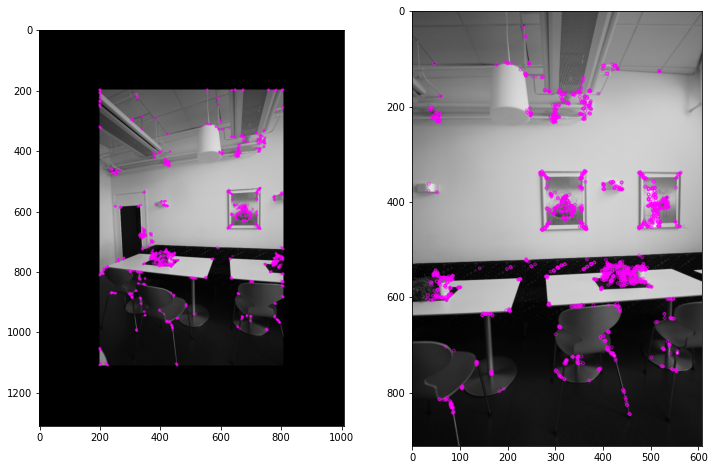

In [38]:
plot_two_imgs(cv2.drawKeypoints(img1, keypoints1, None, (255, 0, 255)), 
             cv2.drawKeypoints(img2, keypoints2, None, (255, 0, 255)))

In [39]:
# Create a BFMatcher object.
# It will find all of the matching keypoints on two images
bf = cv2.BFMatcher()

# Find matching points
matches = bf.knnMatch(descriptors1, descriptors2, k=2)

In [40]:
all_matches = []
for m, n in matches:
    all_matches.append(m)

img3 = drawMatches(img1, keypoints1, img2, keypoints2, all_matches)
plt.imshow(img3)

ValueError: could not broadcast input array from shape (1312,1008,9) into shape (1312,1008,3)

In [41]:
# Finding the best matches
good_matches = []
for m, n in matches:
    if m.distance < 0.5 * n.distance:
        good_matches.append(m)
        
        
img3 = drawMatches(img1, keypoints1, img2, keypoints2, good_matches)
plt.imshow(img3)

ValueError: could not broadcast input array from shape (1312,1008,9) into shape (1312,1008,3)

Transformation Matrix = 
 [[ 2.02877633e+00  2.93435165e-02 -7.98140634e+02]
 [ 5.63688344e-01  1.70602392e+00 -6.58289828e+02]
 [ 1.30451052e-03 -4.76692436e-05  1.00000000e+00]]


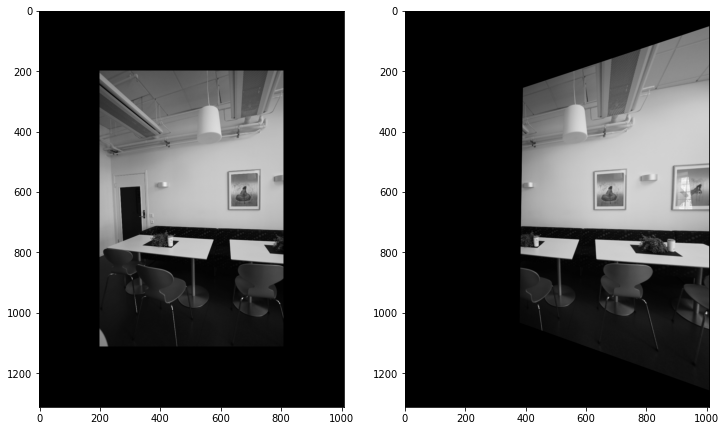

In [42]:
# estimate similarity transform
if len(good_matches) > 10:
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches])
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches])
    # find perspective transform matrix
    rot, mask = cv2.findHomography(src_pts, dst_pts)
    print("Transformation Matrix = \n", rot)
    
    # mapping rotated image back with the calculated rotation matrix
    res4 = cv2.warpPerspective(img2, np.linalg.inv(rot), (img1.shape[1], img1.shape[0]))
else:
    print("Not enough matches are found - %d/%d" % (len(good_matches),4))


plot_two_imgs(img1, res4)

In [43]:
# blend two images
def alpha_blend(img, warped):
    blended_img = cv2.addWeighted(img, 0.52, warped, 0.52, 3)
    
    ret1, mask1 = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY)
    ret2, mask2 = cv2.threshold(warped, 0, 255, cv2.THRESH_BINARY)
    inters_mask = cv2.bitwise_not(cv2.multiply(mask1, mask2))
    
    added_img = cv2.add(img, warped)
    _, union_mask = cv2.threshold(added_img, 0, 255, cv2.THRESH_BINARY)

    sides_mask = cv2.add(cv2.bitwise_not(union_mask), cv2.bitwise_not(inters_mask))
    sides = cv2.subtract(cv2.add(added_img, sides_mask), sides_mask)
    middle = cv2.subtract(cv2.add(blended_img, inters_mask), inters_mask)
    
    blended = cv2.add(middle, sides)
    
    return blended

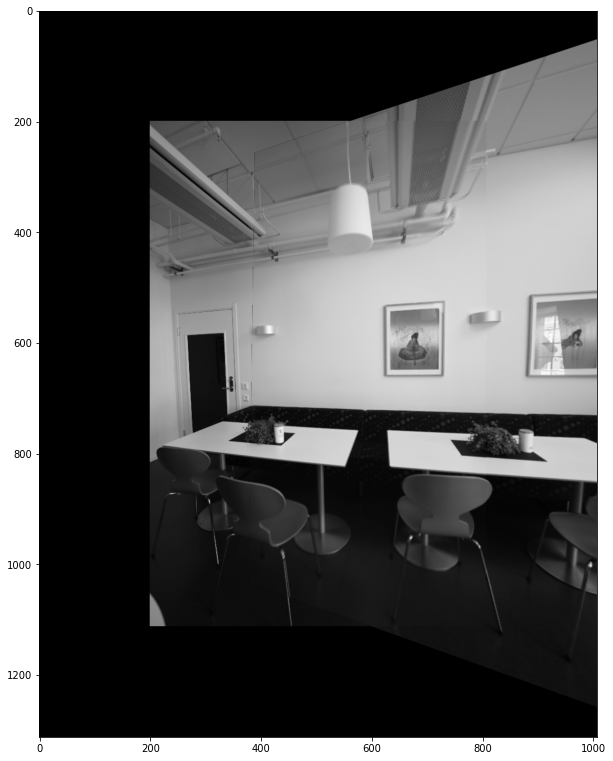

In [44]:
# Blend left and center
stitched_res = alpha_blend(img1, res4)
plt.imshow(stitched_res)

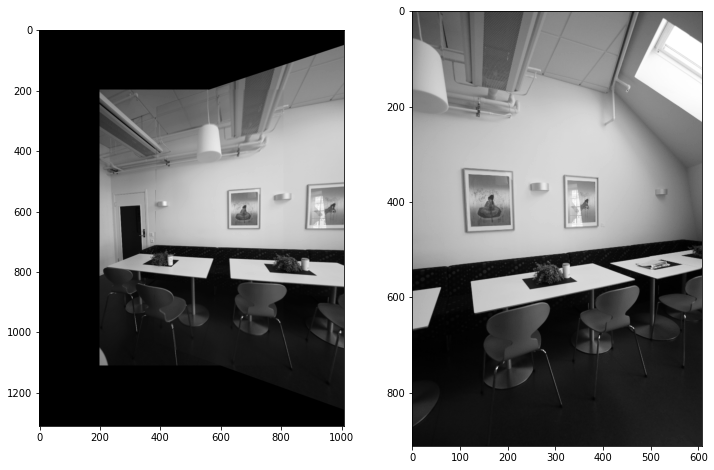

In [45]:
img4 = stitched_res
img5 = cv2.imread("/Users/ann/Documents/GitHub/Computer-Vision-1/Homework 1/SourceImages/stitch_r.png")

img4_gray = cv2.cvtColor(img4, cv2.COLOR_BGR2GRAY)
img5_gray = cv2.cvtColor(img5, cv2.COLOR_BGR2GRAY)

plot_two_imgs(img4_gray, img5_gray)

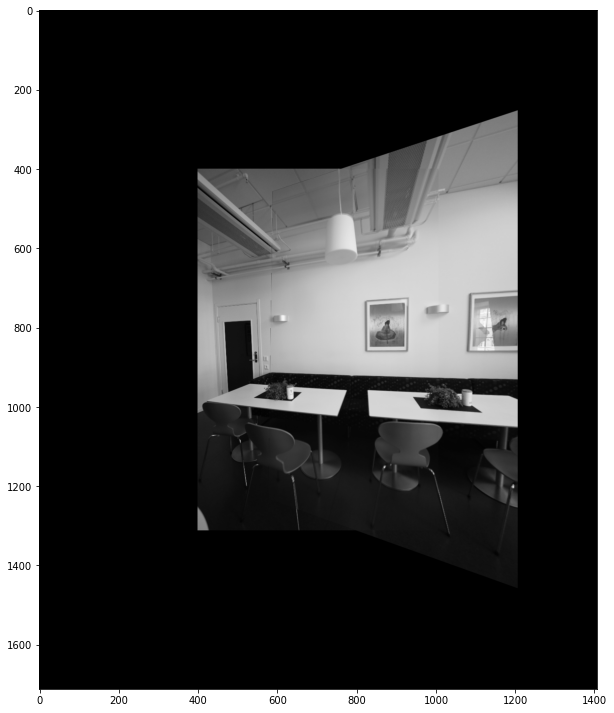

In [47]:
border = 200
img4 = cv2.copyMakeBorder(img4, border, border, border, border, cv2.BORDER_CONSTANT)
plt.imshow(img4)

In [48]:
# Create our ORB detector and detect keypoints and descriptors
orb = cv2.ORB_create(nfeatures=2000)

# Find the key points and descriptors with ORB
keypoints4, descriptors4 = orb.detectAndCompute(img4, None)
keypoints5, descriptors5 = orb.detectAndCompute(img5, None)

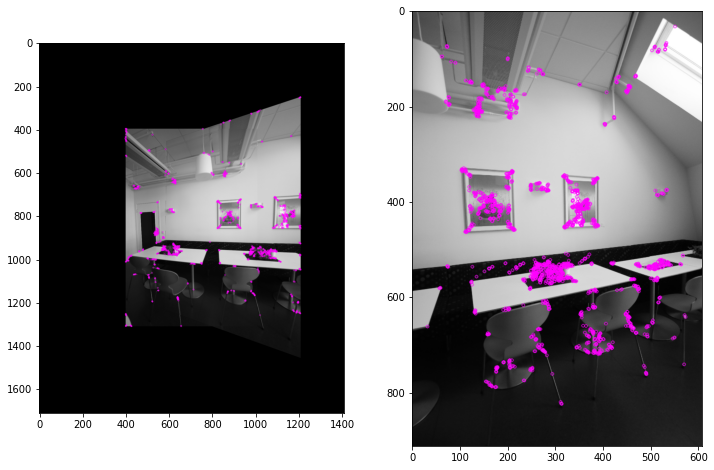

In [49]:
plot_two_imgs(cv2.drawKeypoints(img4, keypoints4, None, (255, 0, 255)), 
             cv2.drawKeypoints(img5, keypoints5, None, (255, 0, 255)))

In [51]:
# Create a BFMatcher object.
# It will find all of the matching keypoints on two images
bf = cv2.BFMatcher()

# Find matching points
matches = bf.knnMatch(descriptors4, descriptors5, k=2)

In [52]:
all_matches = []
for m, n in matches:
    all_matches.append(m)

img6 = drawMatches(img4, keypoints1, img5, keypoints2, all_matches)
plt.imshow(img6)

ValueError: could not broadcast input array from shape (1712,1408,9) into shape (1712,1408,3)

In [53]:
# Finding the best matches
good_matches = []
for m, n in matches:
    if m.distance < 0.5 * n.distance:
        good_matches.append(m)
        
        
img6 = drawMatches(img4, keypoints4, img5, keypoints5, good_matches)
plt.imshow(img6)

ValueError: could not broadcast input array from shape (1712,1408,9) into shape (1712,1408,3)

Transformation Matrix = 
 [[-7.67350304e+00 -2.50331919e-01  5.87046031e+03]
 [-3.77843312e+00 -6.14729330e+00  5.62550891e+03]
 [-8.78361183e-03  2.83640987e-04  1.00000000e+00]]


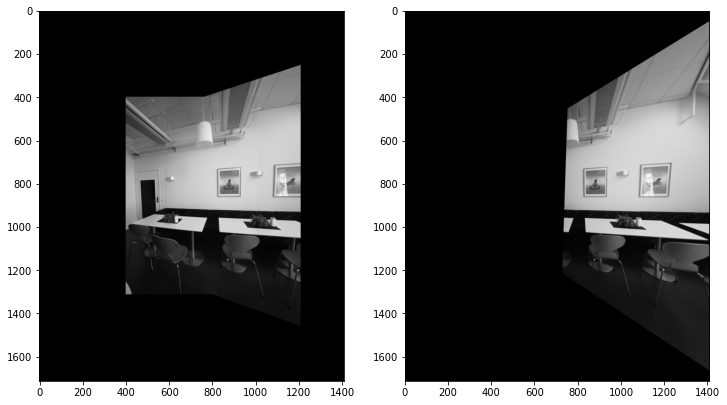

In [54]:
# estimate similarity transform
if len(good_matches) > 10:
    src_pts = np.float32([keypoints4[m.queryIdx].pt for m in good_matches])
    dst_pts = np.float32([keypoints5[m.trainIdx].pt for m in good_matches])
    # find perspective transform matrix
    rot, mask = cv2.findHomography(src_pts, dst_pts)
    print("Transformation Matrix = \n", rot)
    
    # mapping rotated image back with the calculated rotation matrix
    res5 = cv2.warpPerspective(img5, np.linalg.inv(rot), (img4.shape[1], img4.shape[0]))
else:
    print("Not enough matches are found - %d/%d" % (len(good_matches),4))


plot_two_imgs(img4, res5)

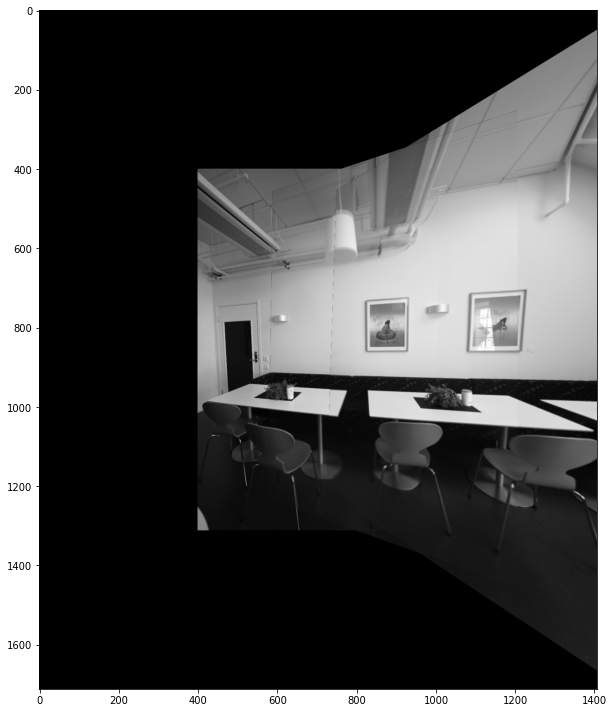

In [56]:
# Blend center and right
stitched_res_f = alpha_blend(img4, res5)
plt.imshow(stitched_res_f)